In [185]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Lasso, ElasticNet, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, clone

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Loading and understanding the data

In [186]:
train_path = './house_price_data/train.csv'
test_path = './house_price_data/test.csv' 

In [187]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

81 features -> 79 features column (except `target` and `id`)

In [188]:
print(train_df.shape)
print(test_df.shape)

(1460, 81)
(1459, 80)


In [189]:
train_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [190]:
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

# Data Processing

In [191]:
train_id = train_df['Id']
test_id = test_df['Id']

train_df.drop(['Id'], axis=1, inplace=True)
test_df.drop(['Id'], axis=1, inplace=True)

train_df.shape, test_df.shape

((1460, 80), (1459, 79))

## Handling outliers


In [192]:
edgecolor = 'black'
sns.set_style('whitegrid') 

def scatter_plot_with_sale_price(column_name):
    plt.scatter(train_df[column_name], train_df['SalePrice'], edgecolor=edgecolor)
    plt.xlabel(column_name)
    plt.ylabel('SalePrice')
    plt.title(f'Scatter plot of {column_name} vs SalePrice')
    plt.show()

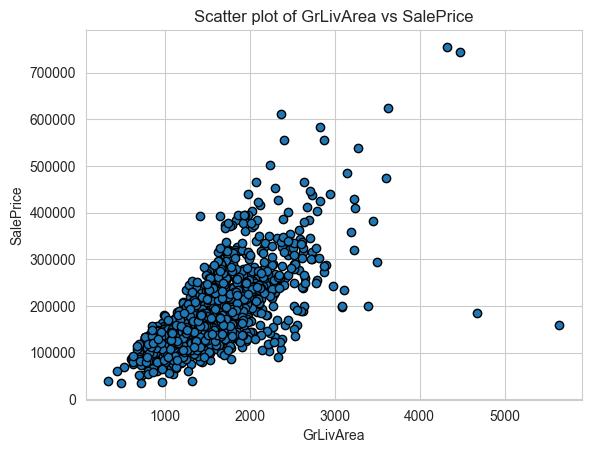

In [193]:
scatter_plot_with_sale_price('GrLivArea')

In [194]:
train_df = train_df.drop(train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 300000)].index)

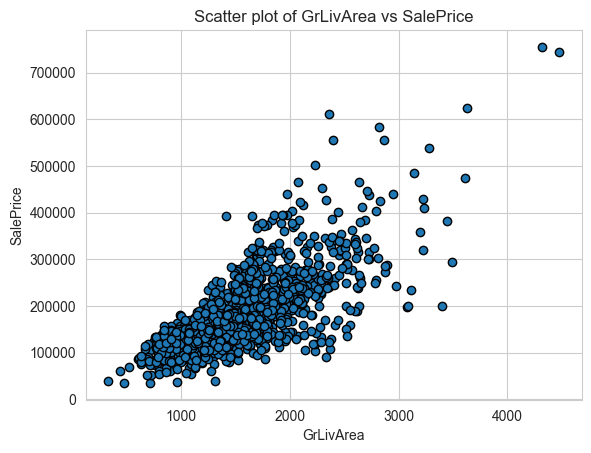

In [195]:
scatter_plot_with_sale_price('GrLivArea')

- Some outliers can negatively affect the prediction highly -> should delete them

<Axes: xlabel='OverallQual', ylabel='SalePrice'>

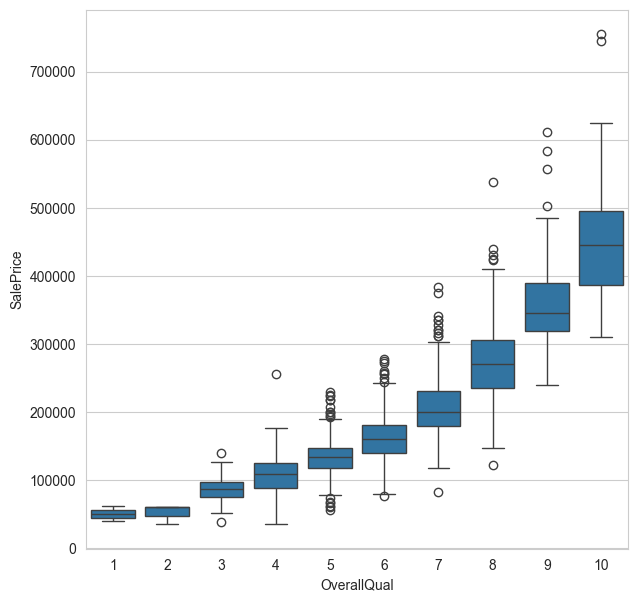

In [196]:
# plot a box for categorical features: OverallQual

plt.figure(figsize=(7, 7))
data = pd.concat([train_df['SalePrice'], train_df['OverallQual']], axis=1)
sns.boxplot(x=train_df['OverallQual'], y='SalePrice', data=data)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111],
 [Text(0, 0, '1872'),
  Text(1, 0, '1875'),
  Text(2, 0, '1880'),
  Text(3, 0, '1882'),
  Text(4, 0, '1885'),
  Text(5, 0, '1890'),
  Text(6, 0, '1892'),
  Text(7, 0, '1893'),
  Text(8, 0, '1898'),
  Text(9, 0, '1900'),
  Text(10, 0, '1904'),
  Text(11, 0, '1905'),
  Text(12, 0, '1906'),
  Text(13, 0, '1908'),
  Text(14, 0,

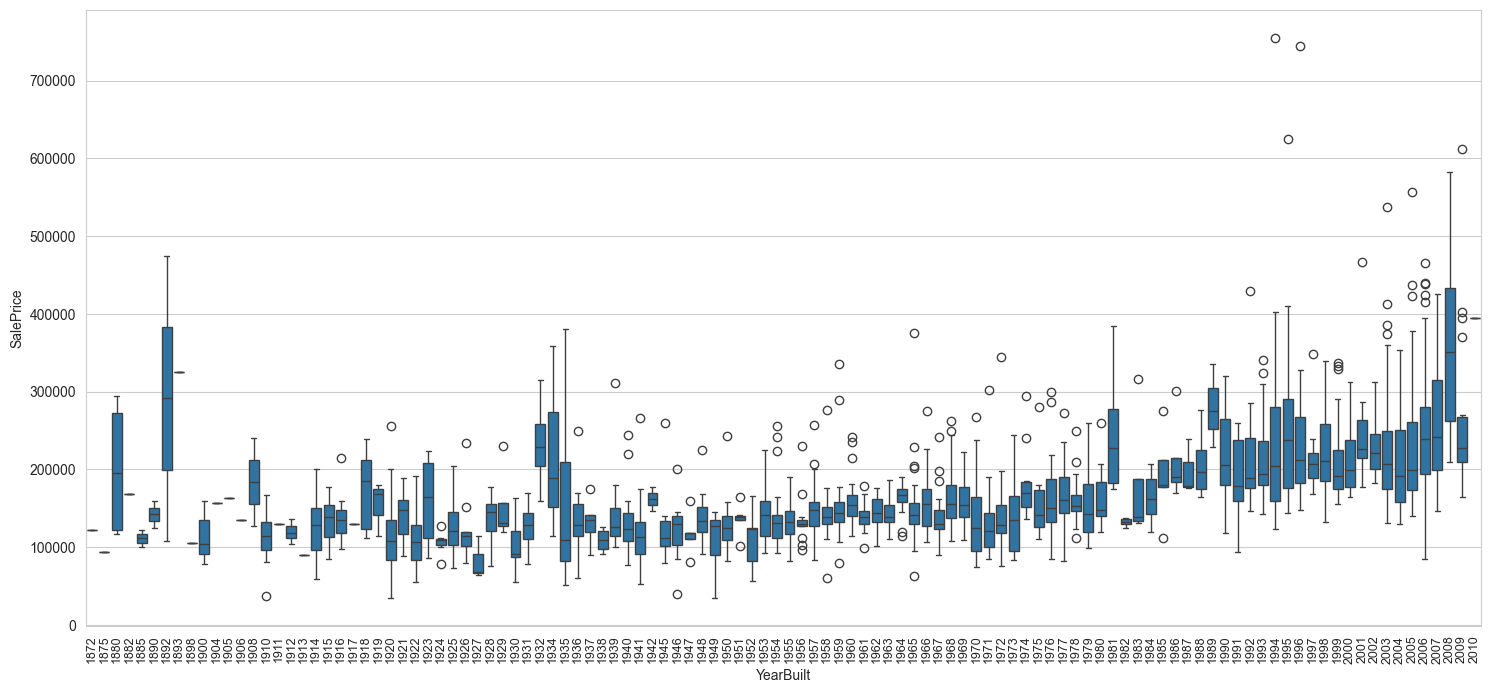

In [197]:
plt.figure(figsize=(18, 8))

data = pd.concat([train_df['SalePrice'], train_df['YearBuilt']], axis=1)
sns.boxplot(x='YearBuilt', y='SalePrice', data=data)
plt.xticks(rotation=90, fontsize=9)


 mu = 180932.92 and sigma = 79467.79



C:\Users\Hiep\AppData\Local\Temp\ipykernel_18464\1403643425.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['SalePrice'] , fit=norm);


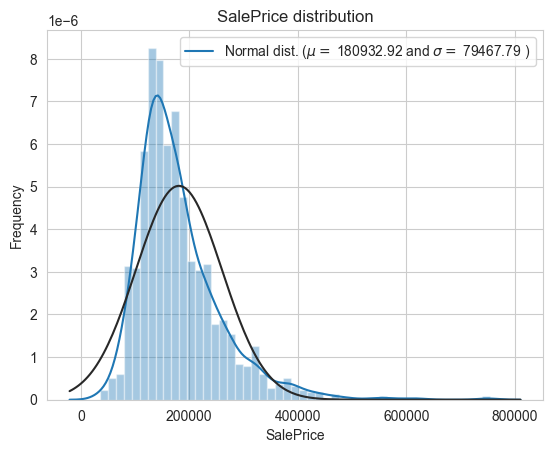

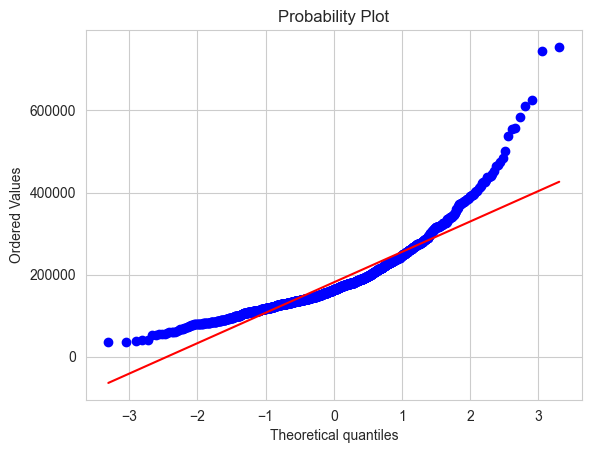

In [198]:
sns.distplot(train_df['SalePrice'] , fit=norm);


(mu, sigma) = norm.fit(train_df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))


plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')


fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()


- Deviation from the normal distribution
- Using Logarithm transformation to reduce skew

mu = 12.02 and sigma = 0.40



C:\Users\Hiep\AppData\Local\Temp\ipykernel_18464\345475066.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['SalePrice'] , fit=norm)


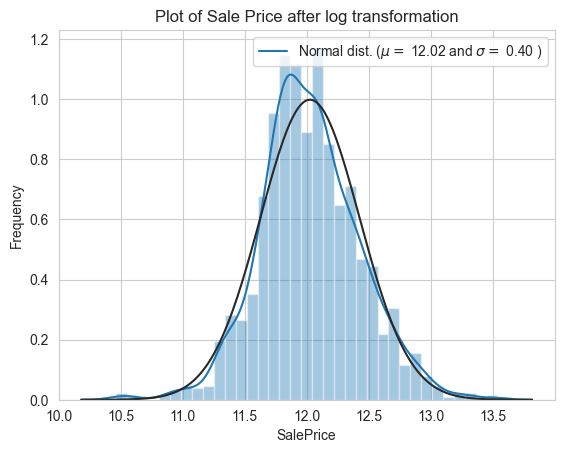

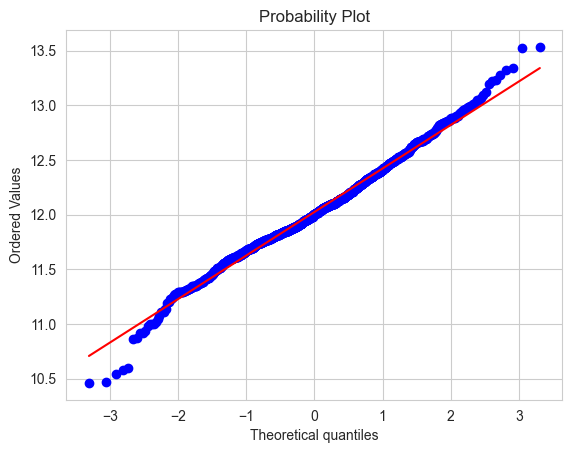

In [199]:
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])
# new distribution
sns.distplot(train_df['SalePrice'] , fit=norm)
(mu, sigma) = norm.fit(train_df['SalePrice'])
print( 'mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Plot of Sale Price after log transformation')

fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

In [200]:
train_df['SalePrice'].describe()

count    1458.000000
mean       12.024015
std         0.399713
min        10.460271
25%        11.774720
50%        12.001512
75%        12.273736
max        13.534474
Name: SalePrice, dtype: float64

## Handling missing data

In [201]:
ntrain = train_df.shape[0]
ntest = test_df.shape[0]
y_train = train_df.SalePrice.values
all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print(f'all_data shape: {all_data.shape}')
train_df.shape, test_df.shape

all_data shape: (2917, 79)


((1458, 80), (1459, 79))

In [202]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
MasVnrType,60.541652
FireplaceQu,48.680151
LotFrontage,16.660953
GarageQual,5.450806
GarageYrBlt,5.450806
GarageCond,5.450806


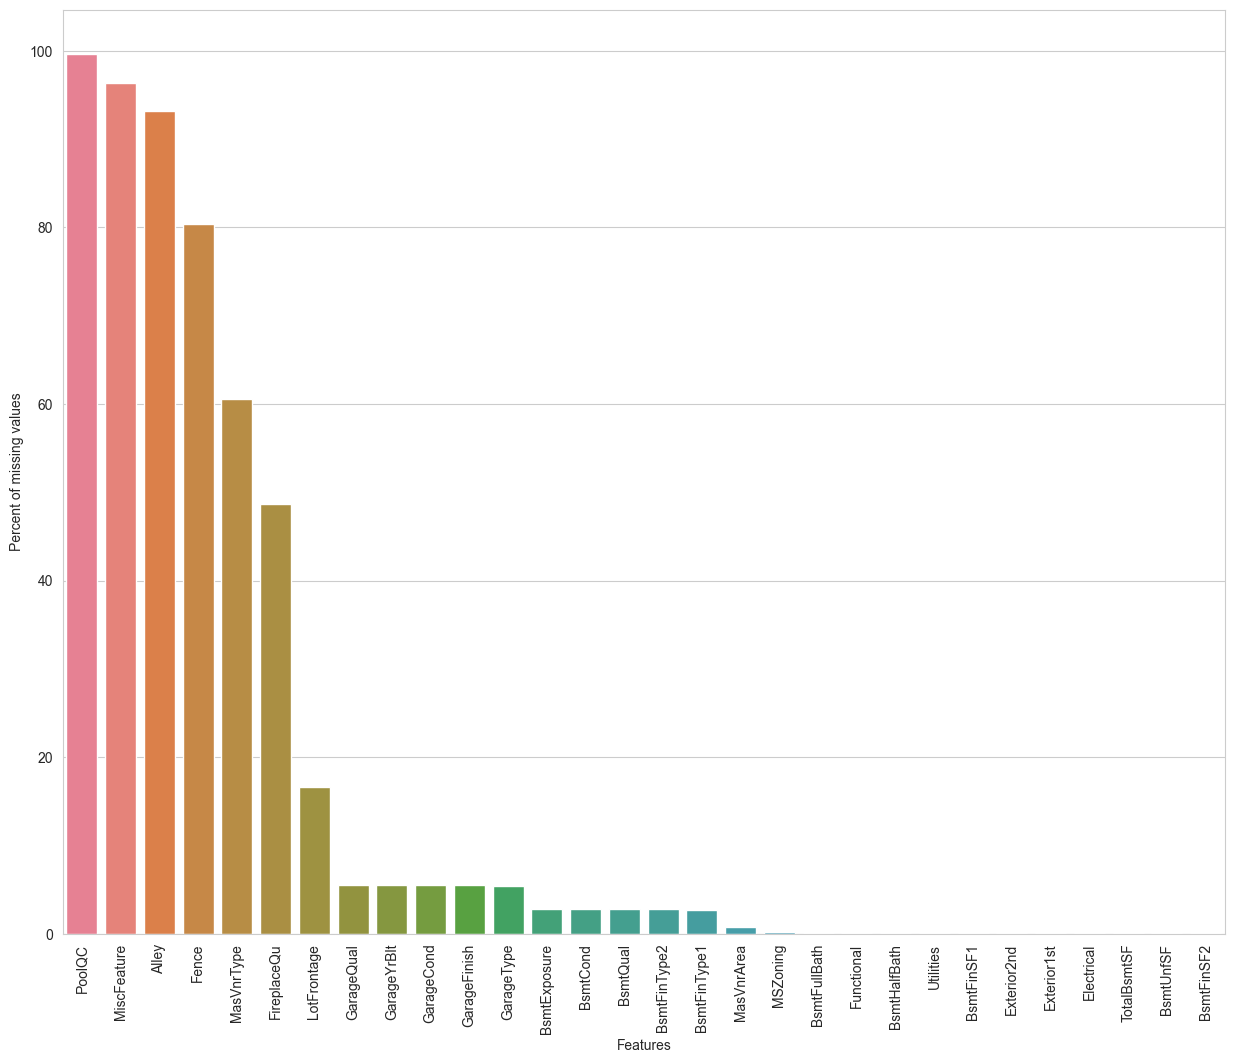

In [203]:
plt.figure(figsize=(15, 12))
plt.xticks(rotation='vertical')
sns.barplot(x=all_data_na.index, y=all_data_na, hue=all_data_na.index)
plt.xlabel('Features')
plt.ylabel('Percent of missing values')
plt.show()

Text(171.72222222222234, 0.5, 'Features')

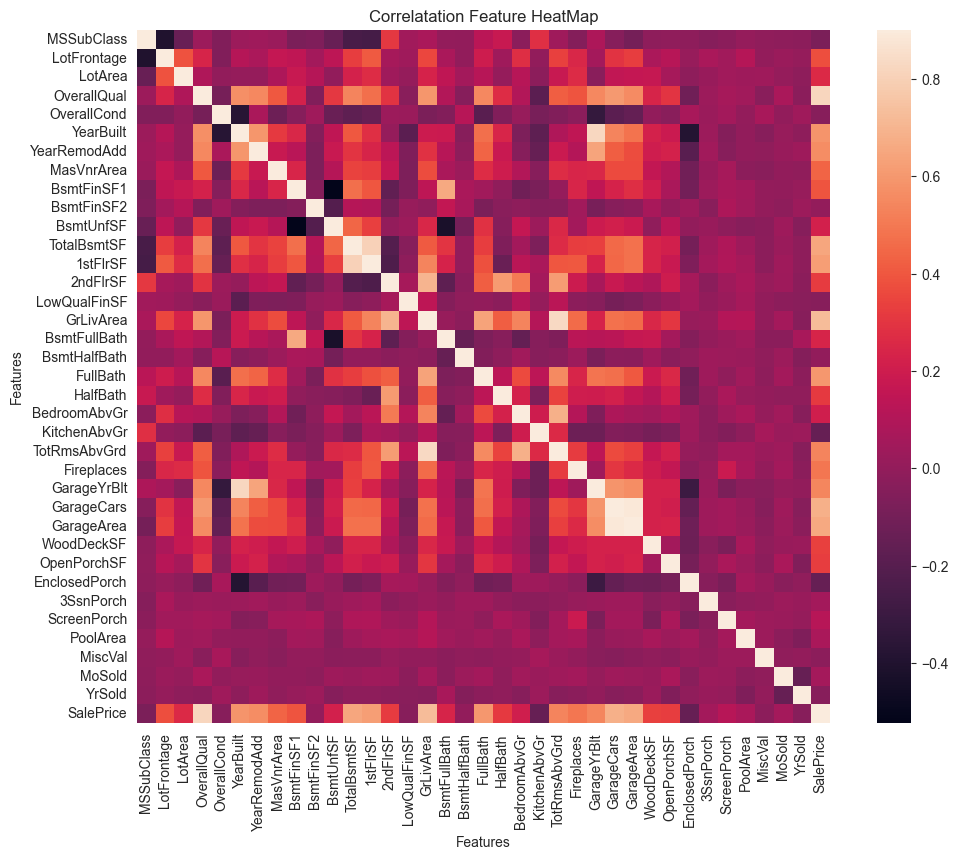

In [204]:
#correlation matrix
corr_mat = train_df.corr(numeric_only=True)
plt.figure(figsize=(12, 9))

sns.heatmap(corr_mat, vmax=.9,square=True)

plt.title("Correlatation Feature HeatMap")
plt.xlabel("Features")
plt.ylabel("Features")

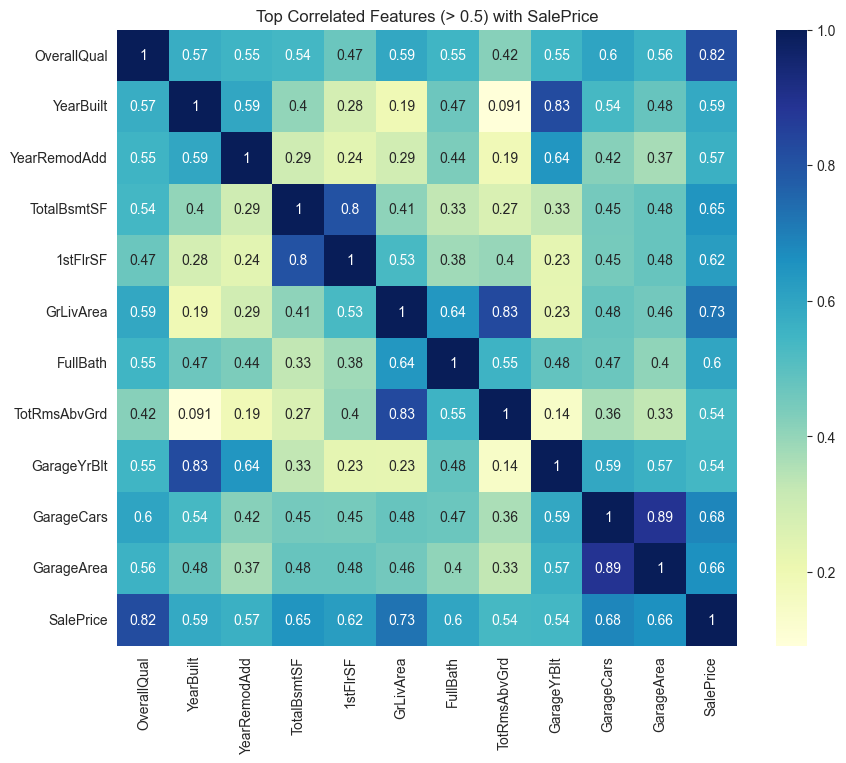

In [205]:
corr_mat = train_df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))

top_corr = corr_mat.index[abs(corr_mat['SalePrice'])>0.5]
sns.heatmap(train_df[top_corr].corr(), annot=True, cmap='YlGnBu')
plt.title("Top Correlated Features (> 0.5) with SalePrice")
plt.show()

- OverallQual and GrLivArea seem to be the most correlated to SalePrice

In [206]:
pd.DataFrame(all_data.nunique(), columns=['Unique Values']).sort_values(by='Unique Values', ascending=True)

,Unique Values
Alley,2
Street,2
Utilities,2
CentralAir,2
MasVnrType,3
...,...
TotalBsmtSF,1056
1stFlrSF,1081
BsmtUnfSF,1135
GrLivArea,1290


In [207]:
def plot_pie_chart(df, cols):
    n = len(cols)
    ncols = 4
    nrows = (n + 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5 * nrows))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        value_counts = df[col].value_counts(dropna=False)
        labels = ['NaN' if pd.isna(val) else str(val) for val in value_counts.index]
        axes[i].pie(value_counts, labels=labels, autopct='%1.1f%%', startangle=90)
        axes[i].set_title(f'Pie Chart of {col}')

    plt.tight_layout()
    plt.show()

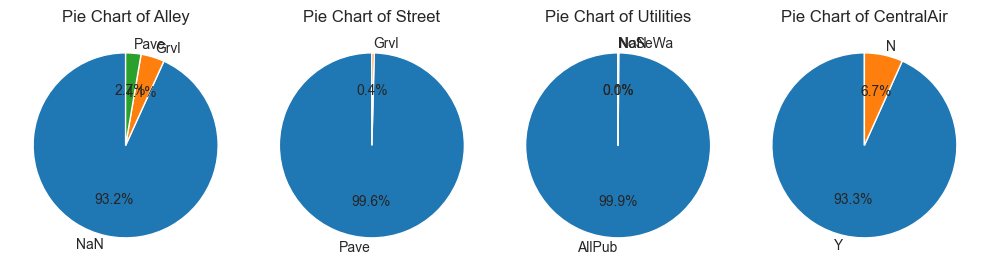

In [208]:
cols = ['Alley', 'Street', 'Utilities', 'CentralAir']

plot_pie_chart(all_data, cols)

- all records mostly "AllPub" for Utilities

In [209]:
def handle_missing(df):

    # drop theses columns due to large null values or many same values
    df = df.drop(['Utilities'], axis=1)

    # Null value likely means No Pool so fill as "None"
    df["PoolQC"] = df["PoolQC"].fillna("None")

    # Null value likely means No Misc Feature so fill as "None"
    df["MiscFeature"] = df["MiscFeature"].fillna("None")

    # Null value likely means No Alley Access so fill as "None"
    df["Alley"] = df["Alley"].fillna("None")

    # Null value likely means No Fence so fill as "None"
    df["Fence"] = df["Fence"].fillna("None")

    # Null value likely means No Fireplace so fill as "None"
    df["FireplaceQu"] = df["FireplaceQu"].fillna("None")

    # Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
    df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(
        lambda x: x.fillna(x.median()))

    # Null value likely means  typical(Typ)
    df["Functional"] = df["Functional"].fillna("Typ")

    # Only one null value so fill as the most frequent value(mode)
    df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])

    # Only one null value so fill as the most frequent value(mode)
    df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

    # Very few null value so fill with the most frequent value(mode)
    df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])

    # Null value likely means no masonry veneer
    # so fill as "None" (since categorical feature)
    df["MasVnrType"] = df["MasVnrType"].fillna("None")
    df["MasVnrArea"] = df["MasVnrArea"].fillna(0)  # so fill as o

    # Only one null value so fill as the most frequent value(mode)
    df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
    df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])

    # MSZoning is general zoning classification,Very few null value so fill with the most frequent value(mode)
    df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])

    # Null value likely means no Identified type of dwelling so fill as "None"
    df['MSSubClass'] = df['MSSubClass'].fillna("None")

    # Null value likely means No Garage, so fill as "None" (since these are categorical features)
    for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
        df[col] = df[col].fillna('None')

    # Null value likely means No Garage and no cars in garage, so fill as 0
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        df[col] = df[col].fillna(0)

    # Null value likely means No Basement, so fill as 0
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
        df[col] = df[col].fillna(0)

    # Null value likely means No Basement, so fill as "None" (since these are categorical features)
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        df[col] = df[col].fillna('None')

    return df

In [210]:
all_data = handle_missing(all_data)

all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


## Transformation data

In [211]:
# Transforming some numerical variables that are really categorical

#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [212]:
def add_new_cols(df):
    
    df['Total_SF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

    df['Total_Bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] 
                             + (0.5 * df['BsmtHalfBath']))

    df['Total_Porch_SF'] = (df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + 
                            df['ScreenPorch'] + df['WoodDeckSF'])

    df['Total_Square_Feet'] = (df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['1stFlrSF'] + df['2ndFlrSF'])
    
    return df

In [213]:
all_data = add_new_cols(all_data)

In [214]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for c in cols:
    lbl = LabelEncoder()
    lbl.fit(all_data[c].values)
    all_data[c] = lbl.transform(all_data[c].values)

print(all_data.shape)

(2917, 82)


In [215]:
# skewed features

numeric_features = all_data.select_dtypes(include=['int64', 'float64']).columns

# Check skew
skewed_feats = all_data[numeric_features].apply(
    lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew': skewed_feats})
skewness.head(10)

,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [216]:
# Box Cox Transformation of (highly) skewed features
skewness = skewness[abs(skewness) > 0.75]
print(f'Highly skewed features: {skewness.shape[0]}')

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

Highly skewed features: 62


In [217]:
# dummy categorical features
all_data = pd.get_dummies(all_data)
all_data.shape

(2917, 223)

In [218]:
# split test set
train = all_data[:ntrain]
test = all_data[ntrain:]

# Modelling

## Define a cross validation strategy

In [219]:
n_folds = 5


def cross_validation(model):
    kf = KFold(n_folds, shuffle=True,
               random_state=42)
    rmse = np.sqrt(-cross_val_score(model, train.values, y_train,
                   scoring='neg_mean_squared_error', cv=kf))
    return (rmse)

## Base Model

- LASSO Regression

In [220]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=43))

- Elastic Net Regression

In [221]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=44))

- Kernal Ridge Regression

In [222]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

- Grandient Boosting Regression

In [223]:
gboost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4,
                                   min_samples_leaf=15, max_features='sqrt',
                                   min_samples_split=10, loss='huber', random_state=45)

- XGBoost

In [224]:
xgb = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =46, nthread = -1)

- LightGBM

In [225]:
lgb = LGBMRegressor(objective='regression', num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin=55, bagging_fraction=0.8,
                              bagging_freq=5, feature_fraction=0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf=6, min_sum_hessian_in_leaf=11)

In [226]:
score = cross_validation(lasso)
print("Lasso score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Lasso score: 0.1121 (0.0082)


In [227]:
score = cross_validation(ENet)
print("ENet score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

ENet score: 0.1122 (0.0082)


In [228]:
score = cross_validation(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1163 (0.0077)



In [229]:
score = cross_validation(gboost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1146 (0.0096)



In [230]:
score = cross_validation(xgb)
print("XGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

c:\Users\Hiep\.conda\envs\data_eng\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:53:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Hiep\.conda\envs\data_eng\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:53:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Hiep\.conda\envs\data_eng\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:53:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Hiep\.conda\envs\data_eng\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:53:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "silent" } are not used.

  bst.update(dtrain,

XGBoost score: 0.1179 (0.0073)



In [231]:
score = cross_validation(lgb)
print("LGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

## Averaged base models class

In [232]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        for model in self.models_:
            model.fit(X, y)

    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [233]:
averaged_models = AveragingModels(models = (ENet, xgb, KRR, lasso))
score = cross_validation(averaged_models)
print("Averaged base models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

c:\Users\Hiep\.conda\envs\data_eng\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:53:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Hiep\.conda\envs\data_eng\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:53:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Hiep\.conda\envs\data_eng\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:53:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Hiep\.conda\envs\data_eng\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:53:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "silent" } are not used.

  bst.update(dtrain,

Averaged base models score: 0.1097 (0.0081)


## Stacking Regressor

In [234]:
base_models = [
    ('ENet', clone(ENet)),
    ('KRR', clone(KRR)),
    ('GBoost', clone(gboost))
]

meta_model = clone(lasso)

In [235]:
stacked_models = StackingRegressor(
    estimators=base_models, final_estimator=meta_model, passthrough=False, cv=5, n_jobs=-1)

In [236]:
score = cross_validation(stacked_models)
print("Stacking score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking score: 0.1083 (0.0091)


## Test with new data

- Lasso score: 0.1115 (0.0073)
- ENet score: 0.1115 (0.0073)
- Kernel Ridge score: 0.1154 (0.0077)
- Gradient Boosting score: 0.1172 (0.0074)
- XGBoost score: 0.1152 (0.0066)
- LGBM score: 0.1154 (0.0053)
- Averaged base models score: 0.1089 (0.0071)
- Stacking score: 0.1087 (0.0072)

In [250]:
def rmse(y_true, y_pred):
    print(root_mean_squared_error(y_true, y_pred))
    return root_mean_squared_error(y_true, y_pred)

- Stacked Model

In [251]:
stacked_models.fit(train, y_train)
stacked_train_pred = stacked_models.predict(train)
stacked_pred = np.expm1(stacked_models.predict(test))
rmse(y_train, stacked_train_pred)

0.0718402278949848


np.float64(0.0718402278949848)

- Averaged base models

In [252]:
averaged_models.fit(train, y_train)
averaged_train_pred = averaged_models.predict(train)
averaged_pred = np.expm1(averaged_models.predict(test))
rmse(y_train, averaged_train_pred)

c:\Users\Hiep\.conda\envs\data_eng\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:12:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


0.08940200653872049


np.float64(0.08940200653872049)

- XGBoost

In [253]:
xgb.fit(train, y_train)
xgb_train_pred = xgb.predict(train)
xgb_pred = np.expm1(xgb.predict(test))
rmse(y_train, xgb_train_pred)

c:\Users\Hiep\.conda\envs\data_eng\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:12:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


0.08603343138126114


np.float64(0.08603343138126114)

- LightGBM

In [254]:
lgb.fit(train, y_train)
lgb_train_pred = lgb.predict(train)
lgb_pred = np.expm1(lgb.predict(test.values))
rmse(y_train, lgb_train_pred)

[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, m

np.float64(0.07049892849944751)

In [ ]:
rmse_avr = stacked_train_pred * 0.7 + lgb_train_pred * 0.15 + xgb_train_pred * 0.15
rmse(y_train, rmse_avr)

0.07129123802701223


np.float64(0.07129123802701223)

In [258]:
ensemble = stacked_pred * 0.7 + lgb_pred * 0.15 + xgb_pred * 0.15

In [259]:
sub = pd.DataFrame()
sub['Id'] = test_id
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)